<a href="https://colab.research.google.com/github/babuus/RNN/blob/master/London%20bike%20sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install livelossplot
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 68.7MB/s]


In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [40]:
df = pd.read_csv("london_bike_sharing.csv",parse_dates=['timestamp'],index_col="timestamp")
print(df.shape)
df.head()

(17414, 9)


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [41]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


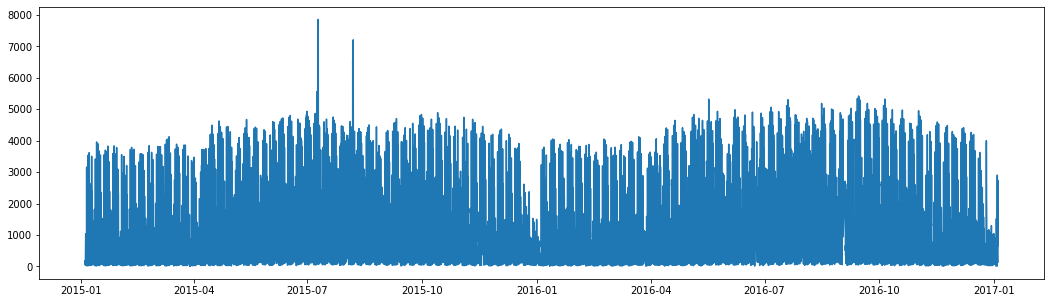

In [42]:
plt.figure(figsize=(18,5))
plt.plot(df['cnt']);

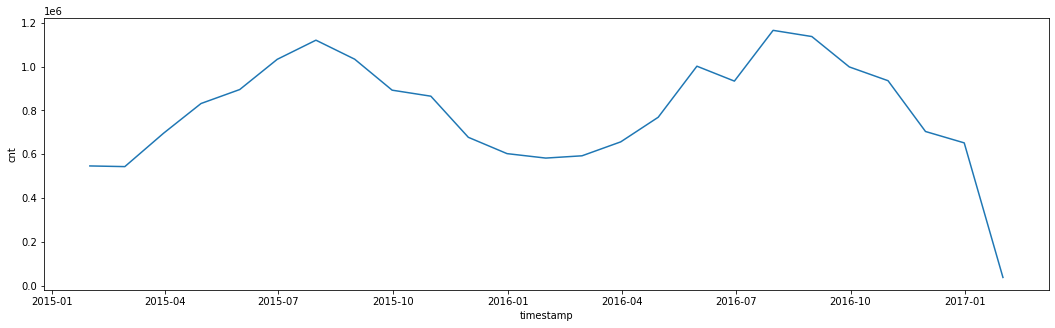

In [43]:
plt.figure(figsize=(18,5))
re_month = df.resample('M').sum()
sns.lineplot(data=re_month, x=re_month.index, y='cnt');

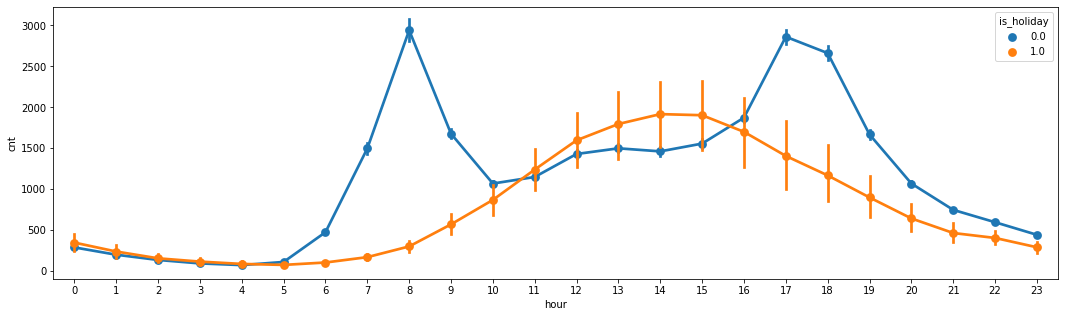

In [44]:
plt.figure(figsize=(18,5))
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday');

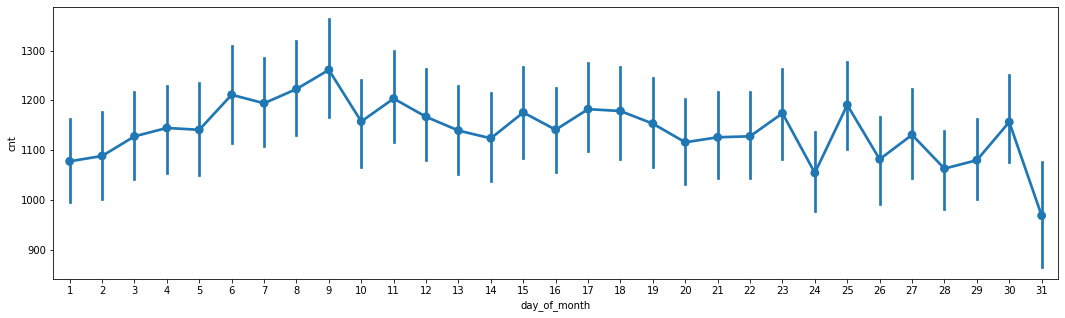

In [45]:
plt.figure(figsize=(18,5))
sns.pointplot(data=df, x='day_of_month', y='cnt');

In [46]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
len(train), len(test)

(15672, 1742)

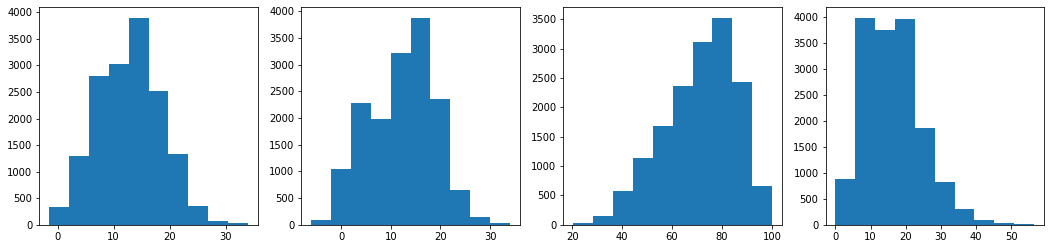

In [47]:
fig, ax = plt.subplots(1,4,figsize=(18,4))
ax[0].hist(train.t1)
ax[1].hist(train.t2)
ax[2].hist(train.hum)
ax[3].hist(train.wind_speed);

In [48]:
f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [49]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [50]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)
print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [51]:
len(X_train) - 10

15652

In [63]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

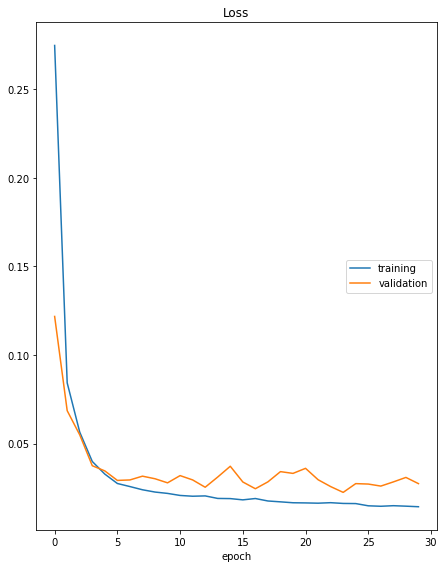

Loss
	training         	 (min:    0.014, max:    0.275, cur:    0.014)
	validation       	 (min:    0.022, max:    0.122, cur:    0.027)


In [64]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False, 
    callbacks=[PlotLossesKeras()]
)

In [93]:
ls = model.evaluate(X_test, y_test)
ls

55/55 [==============================] - 0s 5ms/step - loss: 0.0307


0.030721906572580338

In [65]:
y_pred = model.predict(X_test)

In [68]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1, -1))

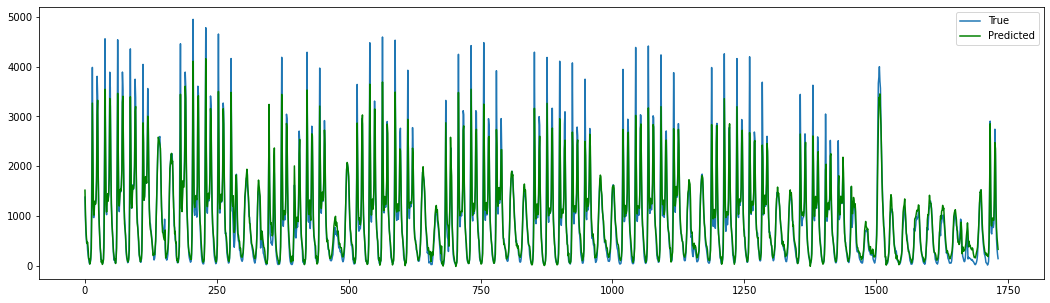

In [81]:
plt.figure(figsize=(18,5))
plt.plot(y_test_inv.flatten(),label='True')
plt.plot(y_pred_inv.flatten(), 'g', label='Predicted')
plt.legend();